# Classical Optical Flow Estimation

## Lucas-Kanade Optical Flow (IJCAI 1981)

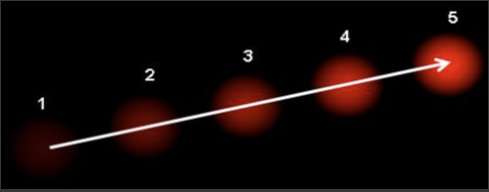

**Citation**
```
@inproceedings{lucas1981iterative,
  title={An iterative image registration technique with an application to stereo vision},
  author={Lucas, Bruce D and Kanade, Takeo},
  booktitle={IJCAI'81: 7th international joint conference on Artificial intelligence},
  volume={2},
  pages={674--679},
  year={1981}
}
```

In [1]:
from typing import *
import numpy as np
from scipy import signal
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
import math

In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip
!unzip data_scene_flow.zip -d ./Kitti/

--2024-08-12 13:34:50--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.136.130, 3.5.136.228, 52.219.170.225, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.136.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1681488619 (1.6G) [application/zip]
Saving to: ‘data_scene_flow.zip’

data_scene_flow.zip 100%[===================>]   1.57G  4.38MB/s    in 5m 48s  

2024-08-12 13:40:40 (4.60 MB/s) - ‘data_scene_flow.zip’ saved [1681488619/1681488619]

Archive:  data_scene_flow.zip
   creating: ./Kitti/training/
   creating: ./Kitti/training/disp_noc_1/
 extracting: ./Kitti/training/disp_noc_1/000033_10.png  
 extracting: ./Kitti/training/disp_noc_1/000076_10.png  
 extracting: ./Kitti/training/disp_noc_1/000194_10.png  
 extracting: ./Kitti/training/disp_noc_1/000137_10.png  
 extracting: ./Kitti/training/disp_noc_1/000110_10.png 

In [3]:
def flow_to_arrow(img: np.ndarray, flow: np.ndarray, scale=20, color=(255, 0, 0), step=25):
    _, h, w = flow.shape
    img_with_flow = img.copy()
    for y in range(0, h, step):
        for x in range(0,w,step):
            dx, dy = flow[:, y, x]
            if abs(dx) > 0. or abs(dy) > 0.:
                cv2.arrowedLine(
                    img_with_flow, (x,y), (int(x + dx*scale), int(y + dy*scale)), color, 2)

    return img_with_flow

## The LK Algorithm

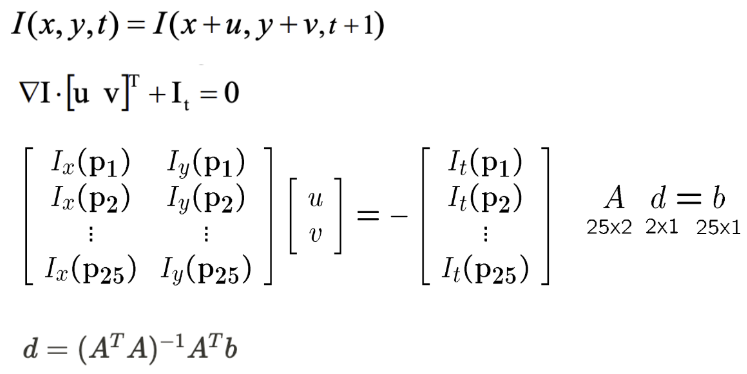

### Good features



In [29]:
def optical_flow(I1g: np.ndarray, I2g: np.ndarray, window_size: int, tau:float =0.1, alpha:float = 0.1) \
    -> Tuple[np.ndarray, np.ndarray]:

    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])
    w = window_size//2
    I1g = I1g / 255.
    I2g = I2g / 255.

    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, mode=mode)

    ######### fy ##########
    fy = signal.convolve2d(I1g, kernel_y, mode=mode)

    ft = signal.convolve2d(I2g, kernel_t, mode=mode) \
         + signal.convolve2d(I1g, -kernel_t, mode=mode)
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)

    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()

            ########### TODO matrix A, vector b define ###########
            b = It
            A = np.concatenate((Ix[:,None], Iy[:,None]), axis=1)
            ###### TODO Write the conditional statement for R, the condition under which optical flow is valid, using the threshold tau. ######
            ATA = A.T @ A
            trace = np.trace(ATA)
            det = np.linalg.det(ATA)
            R = det - alpha * trace**2
            if R < tau:
              continue

            #### TODO Estimate d using the Least Squares method. ####
            d = np.linalg.inv(ATA) @ A.T @ b

            u[i,j]=d[0]
            v[i,j]=d[1]

    return np.concatenate([u[None, ...],v[None, ...]], axis=0)

In [15]:
# configurate
start_idx, end_idx = 13, 17
window_size = 5 # try different window sizes.
tau = window_size*math.sqrt(2)*10
img1_filefmt: str = "./Kitti/training/image_2/%06d_10.png"
img2_filefmt: str = "./Kitti/training/image_2/%06d_11.png"
gt_filefmt: str = "./Kitti/training/flow_occ/%06d_10.png"

## Data

### KITTI Flow 2015

Real dynamic scenes of 200 image pairs in a driving scenario

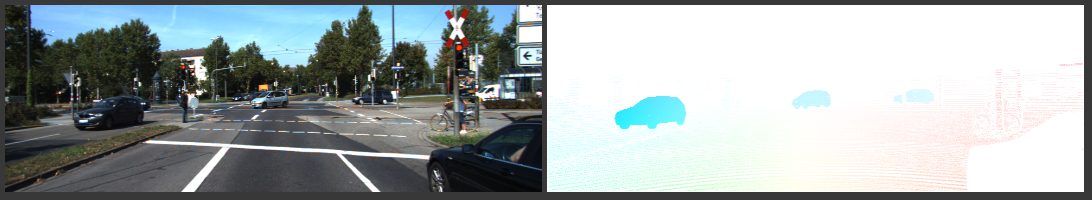

Dataset website: https://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=flow

In [16]:
# load images
img1, img2 = [], []
img1_vis, img2_vis = [], []
gts, valids = [], []
for fidx in range(start_idx, end_idx+1):
    im1 = np.asarray(Image.open(img1_filefmt % fidx))
    im2 =  np.asarray(Image.open(img2_filefmt % fidx))
    img1_vis.append(im1)
    img2_vis.append(im2)

    im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
    im2 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)
    img1.append(im1)
    img2.append(im2)

    gt = cv2.imread(gt_filefmt % fidx, cv2.IMREAD_ANYDEPTH|cv2.IMREAD_COLOR)
    gt = gt[...,::-1].astype(np.float32)
    gt, valid = gt[...,:2], gt[...,2]
    gt = (gt - 2**15) / 64.0
    gts.append(gt.transpose(2,0,1))
    valids.append(valid)

assert len(img1) == len(img2)

In [30]:
# run the Lucas-Kanade algorithm
results = []
flow_imgs = []
i=0
while i < len(img1):
    print(f"Start {i}")
    pred_flow = optical_flow(img1[i], img2[i], window_size=window_size, tau=tau)
    print(f"Finished {i}")
    results.append(pred_flow)

    flow_img = flow_to_arrow(img1_vis[i], pred_flow)
    flow_imgs.append(flow_img)

    flow_img = flow_to_arrow(img2_vis[i], pred_flow)
    flow_imgs.append(flow_img)

    i += 1

Start 0
Finished 0
Start 1
Finished 1
Start 2
Finished 2
Start 3
Finished 3
Start 4
Finished 4


# Iterative Lucas-Kanade Algorithm

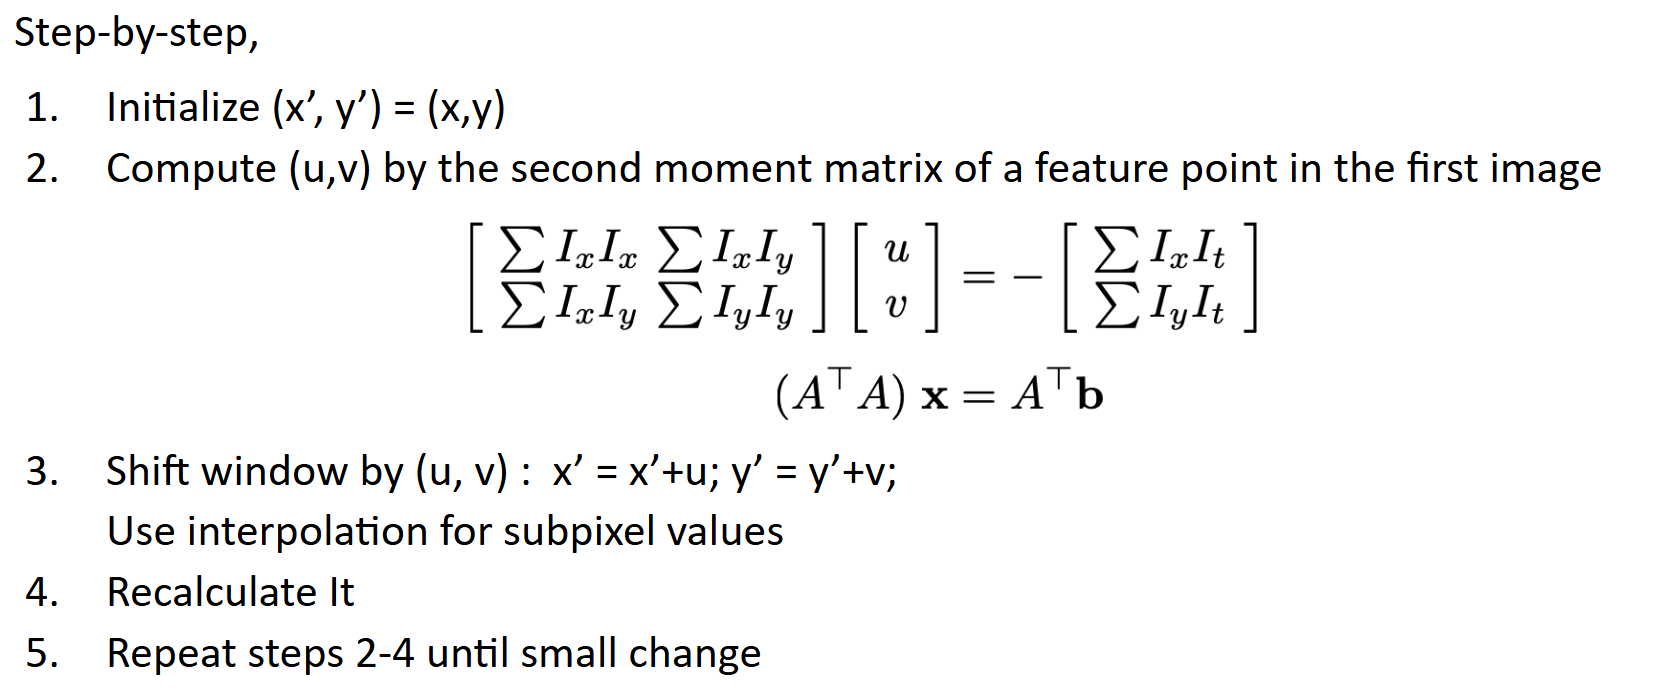

In [31]:
from scipy.ndimage import map_coordinates

def warp_image(I, u, v):
    """Warps the image according to the given optical flow (u, v)."""
    rows, cols = I.shape
    # Calculating new coordinates
    coords_y, coords_x = np.mgrid[0:rows, 0:cols] + [v, u]
    # Obtain the warped image using the mapped coordinates.
    warped_I = map_coordinates(I, [coords_y, coords_x], order=1, mode='reflect')
    return warped_I

def iterative_optical_flow(I1g: np.ndarray, I2g: np.ndarray, window_size: int, num_iterations: int = 3, tau:float =0.1, alpha:float = 0.1) \
    -> Tuple[np.ndarray, np.ndarray]:

    # Obtain the warped image using the mapped coordinates.
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)

    for _ in range(num_iterations):
        #####TODO: Implement the Iterative Lucas-Kanade algorithm using the warp_image and optical_flow functions. #####
        I2g_warped = warp_image(I2g, u, v)
        du, dv = optical_flow(I1g=I1g, I2g=I2g_warped, window_size=window_size, tau=tau, alpha=alpha)

        u = u + du
        v = v + dv

    return np.concatenate([u[None, ...], v[None, ...]], axis=0)

In [32]:
# run the Iterative Lucas-Kanade algorithm
iter_results = []
iter_flow_imgs = []
i=0
while i < len(img1):
    print(f"Start {i}")
    pred_flow = iterative_optical_flow(img1[i], img2[i], window_size=window_size, tau=tau)
    print(f"Finished {i}")
    iter_results.append(pred_flow)

    flow_img = flow_to_arrow(img1_vis[i], pred_flow)
    iter_flow_imgs.append(flow_img)

    flow_img = flow_to_arrow(img2_vis[i], pred_flow)
    iter_flow_imgs.append(flow_img)

    i += 1

Start 0
Finished 0
Start 1
Finished 1
Start 2
Finished 2
Start 3
Finished 3
Start 4
Finished 4


## Evaluation

In [36]:
result_flows = np.stack(results)
iter_result_flows = np.stack(iter_results)

ground_truths = np.stack(gts)
valid_masks = np.stack(valids)
valid_masks = valid_masks >= 0.5

###### TODO: Define and verify the equation for End-point-error, then implement it. ######
epe = np.sqrt(np.sum(result_flows - ground_truths**2, axis=1, keepdims=False))
epe_iter = np.sqrt(np.sum(iter_result_flows - ground_truths**2, axis=1, keepdims=False))

print(f"End point error: {np.mean(epe):.2f}, Image size: {results[0].shape[1]} x {results[0].shape[2]}")
print(f"End point error with iterative version: {np.mean(epe_iter):.2f}, Image size: {iter_results[0].shape[1]} x {iter_results[0].shape[2]}")

End point error: nan, Image size: 375 x 1242
End point error with iterative version: nan, Image size: 375 x 1242


/tmp/ipykernel_973994/2539996815.py:9: RuntimeWarning: invalid value encountered in sqrt
  epe = np.sqrt(np.sum(result_flows - ground_truths**2, axis=1, keepdims=False))
/tmp/ipykernel_973994/2539996815.py:10: RuntimeWarning: invalid value encountered in sqrt
  epe_iter = np.sqrt(np.sum(iter_result_flows - ground_truths**2, axis=1, keepdims=False))


## Results

In [38]:
import imageio

imageio.mimwrite('./output.gif', flow_imgs)
for i, img in enumerate(flow_imgs):
    img =Image.fromarray(img)
    img.save(f"./output_{i//2}_{i%2}.png")

In [39]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path

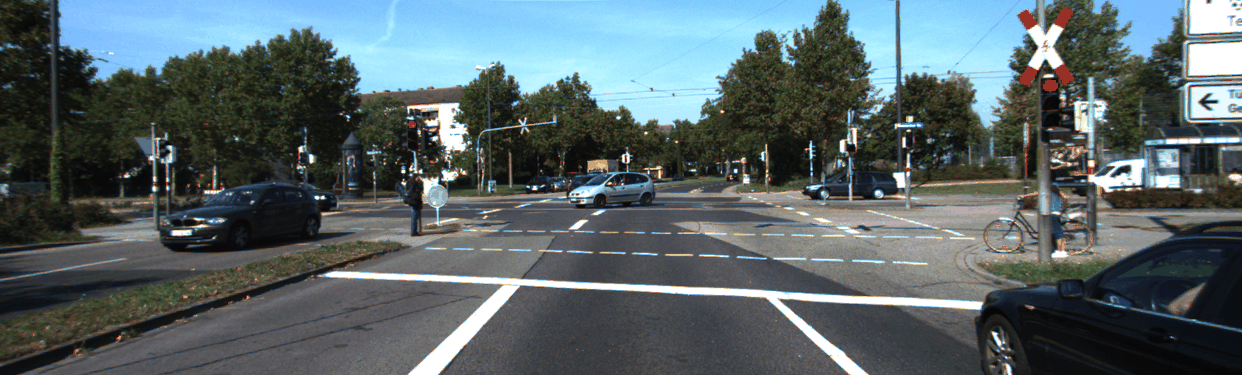

In [40]:
gifPath = Path("./output.gif")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')

In [42]:
## cv2로 구현된 LK 알고리즘 실행 방법 ##

i=0
cv2_flow_imgs = []
while i < len(img1):
    print(f"Start {i}")
    pt0 = cv2.goodFeaturesToTrack(img1[i], maxCorners=1000, qualityLevel=0.3, minDistance=7, blockSize=7)
    pt1, st, err = cv2.calcOpticalFlowPyrLK(img1[i], img2[i], pt0, None)
    good_prev = pt0[st==1]
    good_next = pt1[st==1]
    flow = np.zeros((2,img1[0].shape[0], img1[0].shape[1]))
    for j, (new, old) in enumerate(zip(good_next, good_prev)):
        a, b = new.ravel()
        c, d = old.ravel()
        ### TODO new 특징점과 old 특징점을 사용하여 optical flow 성분 u,v 를 계산하세요 ###
        u, v = a-c, b-d
        c, d = int(c), int(d)

        flow[0,d,c] = u
        flow[1,d,c] = v

    vis = flow_to_arrow(img1_vis[i],flow,step=1, scale=1)
    vis2 = flow_to_arrow(img2_vis[i],flow,step=1, scale=1)
    #vis, vis2 = Image.fromarray(vis), Image.fromarray(vis2)
    cv2_flow_imgs.append(vis)

    vis, vis2 = Image.fromarray(vis), Image.fromarray(vis2)
    vis.save(f'./opencv_{i}_0.png')
    vis2.save(f'./opencv_{i}_1.png')
    i+=1

imageio.mimwrite('./cv2_output.gif', cv2_flow_imgs)

Start 0
Start 1
Start 2
Start 3
Start 4


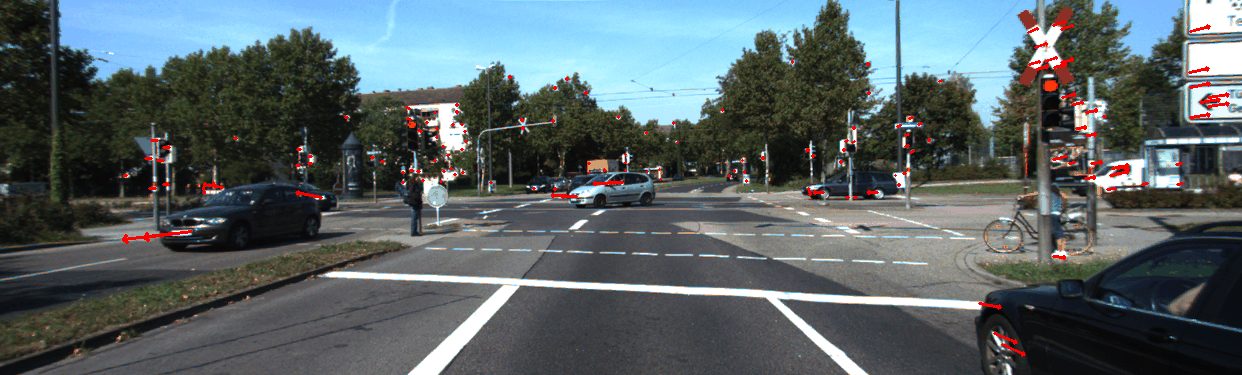

In [45]:
gifPath = Path("./cv2_output.gif")
# Display GIF in Jupyter, CoLab, IPython
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')